In [ ]:
!pip install pymorphy2
!pip install -U 'scikit-learn<0.24'
!pip install stanza
!pip install sklearn-crfsuite

In [ ]:
import pandas as pd
import seaborn as sns
from nltk.tokenize import RegexpTokenizer
from pymorphy2 import MorphAnalyzer
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import sklearn_crfsuite
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics
import scipy
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.model_selection import RandomizedSearchCV
from collections import defaultdict
import stanza
stanza.download('ru')
morph = MorphAnalyzer()
token = RegexpTokenizer('\w+')

In [ ]:
!wget https://github.com/named-entity/hse-nlp/raw/master/4th_year/Project/train_split_aspects.txt
!wget https://github.com/named-entity/hse-nlp/raw/master/4th_year/Project/train_split_reviews.txt

In [10]:
train_asp = pd.read_csv(
    'train_split_aspects.txt', 
    delimiter='\t', 
    names=['text_id', 'category', 'mention', 'start', 'end', 'sentiment']
)
train_texts = pd.read_csv('train_split_reviews.txt', delimiter='\t', names=['text_id','text'])
train_texts

,text_id,text
0,25709,"Были 1 февраля. Я второй раз, подруга - первый..."
1,10099,Были в Дитае на прошлой неделе с подругой. Заш...
2,1105,Один из моих любимых ресторанов. С самого откр...
3,3647,Остались очень довольны. Хотим поблагодарить ш...
4,37070,приехали к друзьям в Питер из Москвы на Новый ...
...,...,...
208,10645,Заезжали поужинать с подругой пару недель наза...
209,12341,"Ходила туда вчера. Интерьер необычный, привлек..."
210,34196,Бронировали столик в прошлые выходные (30.08.1...
211,17475,Была вчера в этом ресторане!Поехала туда не це...


In [11]:
nlp = stanza.Pipeline('ru', processors='tokenize')

2021-12-28 08:45:03 INFO: Loading these models for language: ru (Russian):
| Processor | Package   |
-------------------------
| tokenize  | syntagrus |

2021-12-28 08:45:03 INFO: Use device: gpu
2021-12-28 08:45:03 INFO: Loading: tokenize
2021-12-28 08:45:03 INFO: Done loading processors!


In [13]:
reviews = {}
with open('train_split_reviews.txt') as f:
  for line in f:
    line = line.rstrip('\r\n').split('\t')
    reviews[line[0]] = line[1]

In [68]:
aspects = defaultdict(list)
with open('train_split_aspects.txt') as f:
  for line in f:
    line = line.rstrip('\r\n').split('\t')
    keys = ('category', 'mention', 'start', 'end', 'sentiment')
    aspects[line[0]].append(dict(zip(keys, line[1:])))

Вытаскиваем аспекты и записываем в формате BIO.

In [69]:
bio_texts = []
for text_id, text in tqdm(reviews.items()):
  bio_text = []
  processed = nlp(text)
  postags = []
  for token in processed.iter_tokens():
    add = False
    parse = morph.parse(token.text)[0]
    postag = parse.tag.POS
    if postag is None:
      postag = 'PUNKT'
    postags.append(postag)
    for mention in aspects[text_id]:
      if token.start_char == int(mention['start']) and token.end_char <= int(mention['end']):
        bio_text.append({'text':token.text, 'pos': postag, 'tag':'B-'+mention['category'],
                         'text_id': text_id, 'start': token.start_char, 'end': token.end_char})
        add = True
      elif token.start_char > int(mention['start']) and token.end_char <= int(mention['end']):
        bio_text.append({'text':token.text, 'pos': postag, 'tag':'I-'+mention['category'],
                         'text_id': text_id, 'start': token.start_char, 'end': token.end_char})
        add = True
    if not add:
      bio_text.append({'text':token.text, 'pos': postag, 'tag':'O', 
                       'text_id': text_id, 'start': token.start_char, 
                       'end': token.end_char})
  bio_texts.append(bio_text)

100%|██████████| 213/213 [00:40<00:00,  5.22it/s]


Посмотрим на распределение тегов по всем текстам отзывов.

In [70]:
words = []
tags = []
sents = []
for num, text in enumerate(bio_texts):
  for i in text:
    if i['tag'] != 'O':
      words.append(i['text'])
      tags.append(i['tag'])
      sents.append(train_texts['text'][num])

In [71]:
df = pd.DataFrame(list(zip(words, tags, sents)),
               columns =['words', 'tags', 'sents'])
df['tags'].value_counts()

B-Food        1428
B-Service      908
I-Food         686
B-Whole        610
B-Interior     510
I-Service      209
I-Interior     160
I-Whole        139
B-Price        100
I-Price         19
Name: tags, dtype: int64

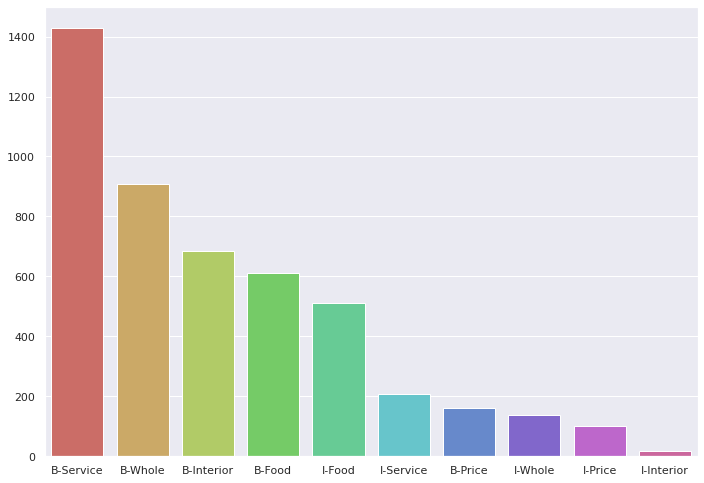

In [72]:
x = list(df['tags'].unique())
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.barplot(
    x=list(df['tags'].unique()), 
    y=df['tags'].value_counts().to_list(), 
    palette='hls',
    data=df);

Распределение очень неравномерное, определить малочисленные аспекты будет тяжело, кроме того, мы убрали из диаграммы все O-теги, которых было около 30 тыс.

### Модель CRF для извлечения аспектов.

In [73]:
def word2features(sent, i):
    # достаёт фичи для i-го токена в предложении
    word = sent[i]['text']
    postag = sent[i]['pos']
    text_id = sent[i]['text_id']
    start = sent[i]['start']
    end = sent[i]['end']

    features = {
        'text_id': text_id, 
        'word': word,
        'word.lower()': word.lower(),
        'word[-3:]': word[-3:],
        'word[-2:]': word[-2:],
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
        'postag': postag,
        'start': start,
        'end': end
    }
    if i > 0:
        word1 = sent[i-1]['text']
        postag1 = sent[i-1]['pos']
        features.update({
            '-1:word.lower()': word1.lower(),
            '-1:word.istitle()': word1.istitle(),
            '-1:word.isupper()': word1.isupper(),
            '-1:postag': postag1,
        })
    else:
        features['BOS'] = True
        
    if i < len(sent)-1:
        word1 = sent[i+1]['text']
        postag1 = sent[i+1]['pos']
        features.update({
            '+1:word.lower()': word1.lower(),
            '+1:word.istitle()': word1.istitle(),
            '+1:word.isupper()': word1.isupper(),
            '+1:postag': postag1,
            '+1:postag[:2]': postag1[:2],
        })
    else:
        features['EOS'] = True
                
    return features

def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

def sent2labels(sent):
    return [word['tag'] for word in sent]

def sent2tokens(sent):
    return [word['text'] for word in sent]

In [74]:
train_sents, test_sents = train_test_split(bio_texts, test_size=0.1, random_state=0, shuffle=True)

In [75]:
X_train = [sent2features(s) for s in train_sents]
y_train = [sent2labels(s) for s in train_sents]

X_test = [sent2features(s) for s in test_sents]
y_test = [sent2labels(s) for s in test_sents]

In [76]:
labels = set()
for x in y_train:
  for y in x:
    labels.add(y)

labels = list(labels)
print(labels)

['B-Price', 'I-Price', 'I-Food', 'I-Whole', 'O', 'B-Food', 'B-Whole', 'I-Interior', 'B-Interior', 'B-Service', 'I-Service']


In [77]:
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs', 
    c1=0.1, 
    c2=0.1, 
    max_iterations=100, 
    all_possible_transitions=True
)
crf.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


CRF(algorithm='lbfgs', all_possible_transitions=True, c1=0.1, c2=0.1,
    keep_tempfiles=None, max_iterations=100)

In [78]:
y_pred = crf.predict(X_test)
metrics.flat_f1_score(y_test, y_pred, 
                      average='weighted', labels=labels)

0.9329482094878352

In [79]:
# group B and I results
sorted_labels = sorted(
    labels, 
    key=lambda name: (name[1:], name[0])
)
print(metrics.flat_classification_report(
    y_test, y_pred, labels=sorted_labels, digits=3
))

              precision    recall  f1-score   support

           O      0.956     0.984     0.970      3286
      B-Food      0.785     0.707     0.744       150
      I-Food      0.806     0.500     0.617        50
  B-Interior      0.794     0.466     0.587        58
  I-Interior      0.167     0.043     0.069        23
     B-Price      1.000     0.667     0.800         6
     I-Price      1.000     0.333     0.500         3
   B-Service      0.814     0.608     0.696        79
   I-Service      0.385     0.312     0.345        16
     B-Whole      0.825     0.855     0.839        55
     I-Whole      0.625     1.000     0.769         5

    accuracy                          0.939      3731
   macro avg      0.741     0.589     0.631      3731
weighted avg      0.932     0.939     0.933      3731



/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=['O', 'B-Food', 'I-Food', 'B-Interior', 'I-Interior', 'B-Price', 'I-Price', 'B-Service', 'I-Service', 'B-Whole', 'I-Whole'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


Здесь мы будем вытаскивать всю нужную нам информацию, чтобы потом записать в файл.

In [80]:
def get_marking(y_pred, X_test):
  d = {'text_id': [], 'tag': [], 'text': [], 'start': [], 'end': []}
  for num, i in enumerate(y_pred):
    for j, tag in enumerate(i):
      if tag!= 'O':
        if i[j].startswith('B') and i[j+1].startswith('I'):
          n=j+1
          tokens = []
          tokens.append(X_test[num][j]['word'])
          start = X_test[num][j]['start']
          while i[n].startswith('I'):
            tokens.append(X_test[num][n]['word'])
            n+=1
          end = X_test[num][n-1]['end']
          t_id = X_test[num][j]['text_id']
          tag = i[j].split('-')[1]
          d['text_id'].append(t_id)
          d['text'].append(' '.join(tokens))
          d['tag'].append(tag)
          d['start'].append(start)
          d['end'].append(end)
        elif i[j].startswith('B') and not i[j+1].startswith('I'):
          d['text_id'].append(X_test[num][j]['text_id'])
          d['tag'].append(i[j].split('-')[1])
          d['text'].append(X_test[num][j]['word'])
          d['start'].append(X_test[num][j]['start'])
          d['end'].append(X_test[num][j]['end'])

  df = pd.DataFrame(data=d)
  return df

In [81]:
get_marking(y_pred, X_test).head()

,text_id,tag,text,start,end
0,34282,Whole,ресторан,31,39
1,34282,Service,обслуживание,96,108
2,34282,Service,принесет меню,167,180
3,34282,Food,блюда,301,306
4,34282,Food,цезарь,359,365


Дальше скачиваем новые данные, на которых будем проверять модель.

In [ ]:
!wget https://github.com/named-entity/hse-nlp/raw/master/4th_year/Project/dev_reviews.txt

In [83]:
dev_texts = pd.read_csv('dev_reviews.txt', delimiter='\t', names=['text_id', 'text'])
dev_texts.head()

,text_id,text
0,13823,"Зашли в""аппетит"" случайно.Не смотря на то,что ..."
1,1427,Здравствуйте!Посетили ваше заведение вчера пер...
2,16714,"Были в пятницу (19.03.10), заказывали столик д..."
3,797,"Были в ресторане 2 раза. Один раз днем, все по..."
4,34710,Удивляюсь отзывам про хорошее обслуживание. Бы...


In [84]:
dev_reviews = {}
with open('dev_reviews.txt') as f:
  for line in f:
    line = line.rstrip('\r\n').split('\t')
    dev_reviews[line[0]] = line[1]

Чтобы подавать сырые тексты в модель, нужно привести их в словари вида:

`{'text':token.text, 'pos': postag, 'text_id': text_id}`





In [85]:
def get_data(dev_reviews):
  all_texts = []
  for text_id, text in tqdm(dev_reviews.items()):
    tokens = []
    processed = nlp(text)
    for token in processed.iter_tokens():
      parse = morph.parse(token.text)[0]
      postag = parse.tag.POS
      if postag is None:
        postag = 'PUNKT'
      postags.append(postag)
      tokens.append({'text':token.text, 'pos':postag, 'text_id':text_id,
                     'start':token.start_char, 'end':token.end_char})
    all_texts.append(tokens)
  return all_texts

In [86]:
all_texts = get_data(dev_reviews)

100%|██████████| 71/71 [00:13<00:00,  5.27it/s]


In [87]:
test_data = [sent2features(s) for s in all_texts]

In [88]:
dev_pred = crf.predict(test_data)

Сортировка полученных данных для того, чтобы потом можно было сравнить с эталонными (эталонные следует так же сортировать).

In [89]:
dev_res = get_marking(dev_pred, test_data)
dev_res['text_id'] = pd.to_numeric(dev_res['text_id'])
dev_res = dev_res.sort_values(by=['text_id'])

In [90]:
dev_res

,text_id,tag,text,start,end
94,785,Service,администратор,416,429
93,785,Service,помогла,392,399
92,785,Food,виды блюд,334,343
91,785,Food,Меню,176,180
89,785,Whole,Ресторан,69,77
...,...,...,...,...,...
911,38299,Interior,обстановка,211,221
910,38299,Whole,заведение,167,176
909,38299,Whole,заведение,74,83
924,38299,Food,кусок мяса с правильной прожаркой,981,1014


Записали в файл и переходим к заданию оценки тональности.

In [91]:
with open('dev_pred_aspects.txt', 'w') as f:
  for text_id, tag, text, start, end in zip(dev_res['text_id'], dev_res['tag'], dev_res['text'], dev_res['start'], dev_res['end']):
      print(text_id, tag, text, start, end, sep="\t", file=f)